### Machine learning for distribution line's flashover predictions

Author: Petar Sarajcev, PhD (petar.sarajcev@fesb.hr)

University of Split, FESB, Department of Power Engineering, R. Boskovica 32, HR21000, Split, Croatia.

In [1]:
import warnings

In [2]:
# Ignore FutureWarning messages
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay
from sklearn.metrics import classification_report, precision_recall_curve

In [5]:
from scipy import integrate
from scipy import interpolate

In [6]:
import seaborn as sns
sns.set(context='paper', style='darkgrid', font_scale=1.25)
sns.set_style('ticks', {'xtick.direction':'out', 'ytick.direction':'out'})

In [7]:
# Private modules
import distlines
import sandbox

### Distribution line indirect lightning strikes

There are, generally speaking, a total of five different modes in which lightning strike interacts with a distribution line, which can be subdivided into: (a) direct strikes and (b) indirect strikes. A direct strike can (a1) end up on a phase conductor when the shield wire is not present, or (a2) it can circumvent the shield wire to strike a phase conductor, which is known as the shielding failure. Also, a direct strike can (a3) end up on a shield wire (when it is present on the line), which can result with a backflashover incident. Furthermore, an indirect lightning strike into the near-by ground (up to several hundred meters from the line) can also initiate a flashovers (b1) with or (b2) without the presence of a shield wire, due to the electromagnetic pulse that is radiated from the lightning channel and coupled by the line conductors.

In [8]:
# INPUT DATA:
# ===========
# Number of random samples
N = 1000

# Multiple distribution lines (example)
# ---------------------------
# Geometry is in meters
y = np.asarray([12., 15.], dtype=float)
h = y + 1.5  # shield wire height
# distance between shield wires
sg = np.repeat(3., repeats=len(y))

# Critical flashover voltage of the line (kV)
line_cfo = np.asarray([150., 160.], dtype=float)

Distribution lines' lightning flashovers data set, for training the subsequent machine learning model, is generated by means of the Monte~Carlo simulation. Statistical probability of lightning flashovers on distribution lines depends on several important parameters, each of which with its own statistical distribution: (1) lightning current amplitude, (2) lightning return stroke velocity, (3) lightning strike distance from the line, (4) OHL tower's grounding impedance, (5) shield wire's presence on the tower, and (6) EGM model type.

In [9]:
# Monte Carlo simulations
data = distlines.generate_dataset(N, h, y, sg, line_cfo)
# View data sample
data.head()

,dist,ampl,shield,veloc,Ri,EGM,CFO,height,flash
0,412.725794,27.214728,1,126.275781,51.116586,Love,150.0,12.0,0.0
1,45.371322,25.092905,1,468.520413,49.611170,AW,150.0,12.0,1.0
2,254.024465,30.294546,0,201.943806,48.783936,Love,150.0,12.0,0.0
3,158.915473,18.111636,1,401.074796,33.500534,Young,150.0,12.0,0.0
4,285.754040,80.457445,1,83.822389,50.769382,Anderson,150.0,12.0,0.0


In [10]:
# Group data by distribution lines
groups = data.groupby('height')

# EXAMPLE: 15 m high dist. line
# -----------------------------
g = groups.get_group(15)
g.reset_index(inplace=True)

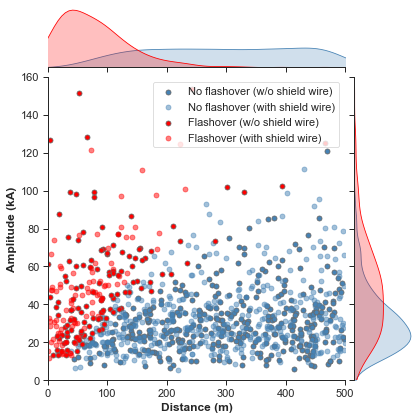

In [11]:
# Plot realizations with marginal distributions
sandbox.plot_realizations(g['dist'], g['ampl'], g['flash'], g['shield'], save_fig=True)

### Flashover predictions with Support Vector Machine based ensemble

We will start with two features: distance of the strike point and lightning current amplitude, and we'll add other features later. It is expected that the prediction accuracy of the model will increase with adding other features. Additional features of particular interest are: height of the distribution line, presence of the shield wires, and impulse impedance of the tower grounding.

In [12]:
# Prepare training data set for scikit-learn
X_data = g[['dist', 'ampl']]  # add features here
y_data = g['flash']

In [13]:
# Stratified Shuffle Split dataset into train and test sets
X, y, X_test, y_test = sandbox.train_test_shuffle_split(X_data, y_data)

Ensemble learning is a machine learning paradigm in which multiple models (often called base models) are trained to tackle the same (classification) problem and then combined, by aggregating predictions or with a meta-model, to yield better performance. Models can be combined in different ways, leading to different techniques for creating ensembles.

Bagging ensemble is built by means of bootstrap aggregating multiple base models, which reduces overall variance and helps avoid overfitting. Each base model is individually trained on the subset of training samples, drawn with replacement from the original set (i.e. bootstrap sample). Individual predictions of the base models are then aggregated by averaging their prediction probabilities.

##### Bagging Ensemble Classifier from SVMs

In [14]:
# Choose the bagging classifier variant
variant = 'B'

In [15]:
if variant == 'A':
    # Off-the-shelf bagging classifier
    n_models = 8  # Enter number of models for the ensemble
    # Model training with hyperparameters optimization
    search = sandbox.bagging_classifier(n_models, X, y, sample_pct=0.8)

elif variant == 'B':
    # hand-made bagging classifier
    n_models = 3  # Enter number of models for the ensemble
    # Model training with hyperparameters optimization
    search = sandbox.bagging_ensemble_svm(n_models, X, y, sample_pct=0.9)

else:
    raise NotImplementedError('Variant is not recognized!')

Train model 1 of 3:
Working ...
Execution time (hour:min:sec): 0:00:01.835355
estimator__C :: 10.185356321325402
estimator__gamma :: auto
estimator__kernel :: linear
preprocess :: StandardScaler()
Train model 2 of 3:
Working ...
Execution time (hour:min:sec): 0:00:00.362130
estimator__C :: 25.933119332066433
estimator__gamma :: scale
estimator__kernel :: linear
preprocess :: StandardScaler()
Train model 3 of 3:
Working ...
Execution time (hour:min:sec): 0:00:11.645179
estimator__C :: 53.922838447263835
estimator__gamma :: scale
estimator__kernel :: rbf
preprocess :: None
Aggregating predictions:
With equal weights.
Working ...
Done.


In [16]:
# Prepare meshgrid for prediction
xx = np.linspace(0, 400, 100)
yy = np.linspace(0, 160, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

In [17]:
probas = search.predict_proba(Xfull)[:,1]
zz = probas.reshape(xx.shape)

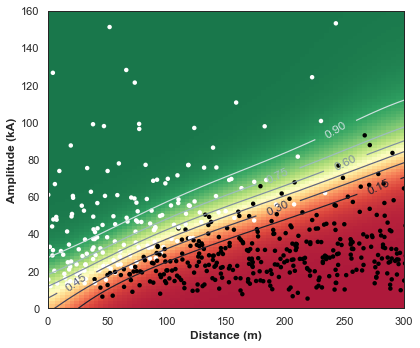

In [18]:
# Show decision boundary
fig, ax = plt.subplots(figsize=(6,5))
# Setup colormap from seaborn
#cmap_diverge = sns.diverging_palette(250, 12, s=75, l=25, as_cmap=True)
ax.pcolormesh(xx, yy, zz, cmap=plt.cm.RdYlGn, shading='nearest', alpha=0.9)
# Show contour lines
contour = plt.contour(xx, yy, zz, cmap=plt.cm.bone)
plt.clabel(contour, inline=1, fontsize=12)
# Show data from the training set
ax.scatter(X[:,0], X[:,1], c=y, edgecolors='none', cmap=plt.cm.bone, s=20)
ax.set_xlabel('Distance (m)', fontweight='bold')
ax.set_ylabel('Amplitude (kA)', fontweight='bold')
ax.set_xlim(0,300)
ax.set_ylim(0,160)
fig.tight_layout()
plt.savefig('decision_boundary.png', dpi=600)
plt.show()

__Support vectors__

SVM (as a base estimator) provides support vectors which serve as a scaffolding around the curve of limiting parameters (CLP). The CLP, at the same time, features prominently in the process of statistical insulation coordination; see IEC TR 60071-4:2004 for more information.

In [19]:
# Extract support vectors from the base models
vectors = sandbox.support_vectors(variant, search, n_models, X, y)

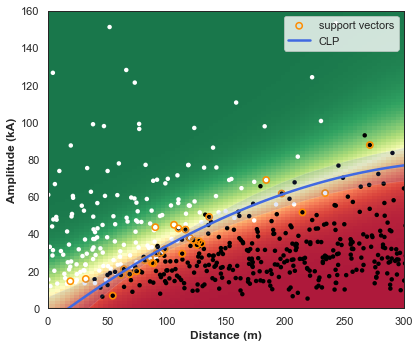

In [20]:
# Curve of Limiting Parameters (CLP)
fig, ax = plt.subplots(figsize=(6,5))
ax.pcolormesh(xx, yy, zz, cmap=plt.cm.RdYlGn, shading='nearest', alpha=0.9)
# Show data from the training set
ax.scatter(X[:,0], X[:,1], c=y, edgecolors='none', cmap=plt.cm.bone, s=20)
# Indicate support vectors
ax.scatter(vectors[:,0], vectors[:,1], facecolor='none',  
           edgecolor='darkorange', s=40, linewidths=1.5, label='support vectors')
# Fit and plot CLP regression curve through the support vectors
sns.regplot(x=vectors[:,0], y=vectors[:,1], fit_reg=True, order=2,  
            truncate=False, scatter=False, color='royalblue',
            line_kws={'lw': 2.5},
            ax=ax, label='CLP')
ax.legend(loc='upper right', frameon='fancy', fancybox=True)
ax.set_xlabel('Distance (m)', fontweight='bold')
ax.set_ylabel('Amplitude (kA)', fontweight='bold')
ax.set_xlim(0,300)
ax.set_ylim(0,160)
fig.tight_layout()
plt.savefig('classify_plot.png', dpi=600)
plt.show()

Additional different CLP curve regression possibilities

In [21]:
# Analysis of CLP as a regression curve through the support vectors
# Least squares regression
y_vectors = vectors[:,1]
X_vectors = np.c_[vectors[:,0], vectors[:,0]**2]  # 2-order poly
X_vectors = sm.add_constant(X_vectors)  # add intercept
ols = sm.OLS(endog=y_vectors, exog=X_vectors).fit(method='qr')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     91.56
Date:                Wed, 14 Sep 2022   Prob (F-statistic):           9.80e-14
Time:                        12:13:48   Log-Likelihood:                -120.81
No. Observations:                  34   AIC:                             247.6
Df Residuals:                      31   BIC:                             252.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0895      4.795     -1.687      0.102     -17.870       1.691
x1             0.4826      0.055      8.736      0.000       0.370       0.595
x2            -0.0007      0.000     -5.804      0.000      -0.001      -0.000
==============================================================================
Omnibus:                        4.142   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                3.157
Skew:                           0.742   Prob(JB):                        0.206
Kurtosis:                       3.163   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
v = np.linspace(0, 300, 100)
x_data = np.c_[v, v**2]
x_data = sm.add_constant(x_data)
# Predict on new data with 95% confidence and prediction intervals
predictions = ols.get_prediction(x_data).summary_frame(alpha=0.05)

In [23]:
predictions.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-8.089519,4.795412,-17.869827,1.690789,-28.618898,12.439860
1,-6.633269,4.641577,-16.099827,2.833289,-27.015043,13.748505
2,-5.189222,4.490382,-14.347416,3.968972,-25.429615,15.051171
3,-3.757379,4.341873,-12.612686,5.097929,-23.862539,16.347781
4,-2.337739,4.196099,-10.895740,6.220263,-22.313733,17.638256


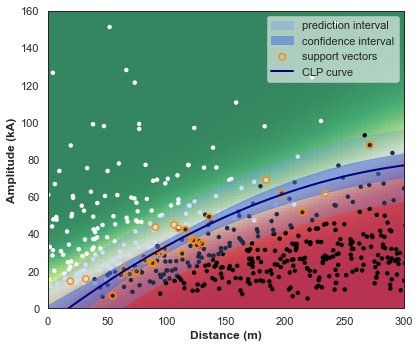

In [24]:
sandbox.regression_plot(X, y, vectors, v, predictions, xx, yy, zz, save_fig=True)

In [25]:
# Spline regression
spline = SplineTransformer(degree=2, n_knots=3, extrapolation='continue')
X_spline = spline.fit_transform(vectors[:,0].reshape(-1, 1))
spl = sm.OLS(endog=y_vectors, exog=X_spline).fit()
spl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     75.44
Date:                Wed, 14 Sep 2022   Prob (F-statistic):           4.48e-14
Time:                        12:13:49   Log-Likelihood:                -117.19
No. Observations:                  34   AIC:                             242.4
Df Residuals:                      30   BIC:                             248.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -26.8363     13.186     -2.035      0.051     -53.766       0.093
x2            43.3410      5.071      8.546      0.000      32.984      53.698
x3           106.2455      7.474     14.215      0.000      90.981     121.510
x4            10.1376     19.420      0.522      0.605     -29.523      49.798
==============================================================================
Omnibus:                        1.353   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.508   Jarque-Bera (JB):                0.897
Skew:                           0.398   Prob(JB):                        0.639
Kurtosis:                       2.976   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
X_spline_new = spline.transform(v.reshape(-1, 1))
# Predict on new data with 95% confidence and prediction intervals
predictions = spl.get_prediction(X_spline_new).summary_frame(alpha=0.05)

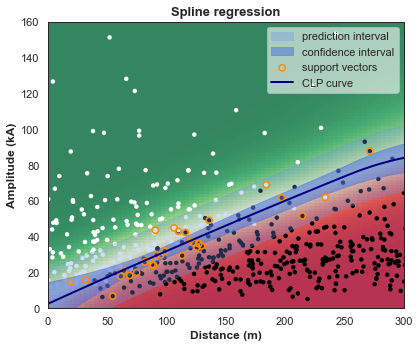

In [27]:
sandbox.regression_plot(X, y, vectors, v, predictions, xx, yy, zz, 
                        'Spline regression')

##### Classification metrics and calibration

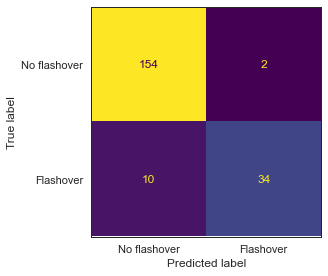

In [28]:
# Plot confusion matrix for estimator
ConfusionMatrixDisplay.from_estimator(
    search, X_test, y_test, 
    display_labels=['No flashover', 'Flashover'],
    #cmap=plt.cm.RdYlBu,
    colorbar=False,
)
plt.tight_layout()
plt.savefig('confusion.png', dpi=600)
plt.show()

In [29]:
y_test_scores = search.predict(X_test)

# Display classification report
print(classification_report(
      y_test, y_test_scores, 
      target_names=['No flashover', 'Flashover']))

              precision    recall  f1-score   support

No flashover       0.94      0.99      0.96       156
   Flashover       0.94      0.77      0.85        44

    accuracy                           0.94       200
   macro avg       0.94      0.88      0.91       200
weighted avg       0.94      0.94      0.94       200



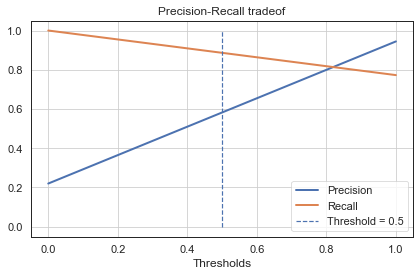

In [30]:
# Precision - Recall trade off for classifier calibration
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_scores)

fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('Precision-Recall tradeof')
ax.plot(thresholds, precisions[:-1], lw=2, label='Precision')
ax.plot(thresholds, recalls[:-1], lw=2, label='Recall')
plt.vlines(0.5, 0, 1, linestyles='--', label='Threshold = 0.5')
ax.set_xlabel('Thresholds')
ax.legend(loc='best')
ax.grid()
fig.tight_layout()
#plt.savefig('precision-recall.png', dpi=600)
plt.show()

From the precision recall trade-off diagram it can be seen that the precision of the classifier can be significantly increased on the expense of only slightly reduced recall, by pushing the threshold level up from the baseline value.

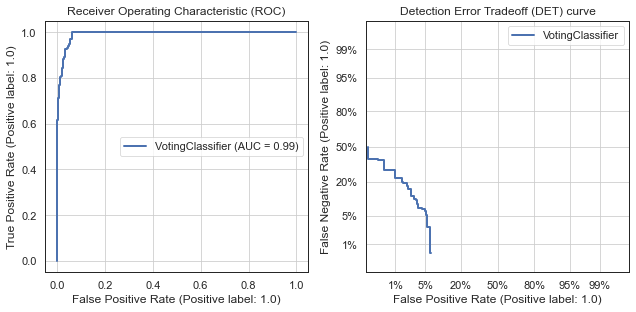

In [31]:
# ROC & DET curves with a default threshold
fig, ax = plt.subplots(1, 2, figsize=(9,4.5))
RocCurveDisplay.from_estimator(search, X, y, ax=ax[0], lw=2)
DetCurveDisplay.from_estimator(search, X, y, ax=ax[1], lw=2)
ax[0].legend(loc='center right')
ax[1].legend(loc='upper right')
ax[0].set_title('Receiver Operating Characteristic (ROC)')
ax[1].set_title('Detection Error Tradeoff (DET) curve')
ax[0].grid()
ax[1].grid()
fig.tight_layout()
#plt.savefig('roc_det_curves.png', dpi=600)
plt.show()

##### Marginal distributions

Machine learning model enables deriving a cumulative distribution function of the distribution line's insulation flashover (i.e. performance function), which features prominently in the risk of insulation flashover analysis.

In [32]:
yv = np.linspace(0, 160, 200)
distances = [0., 50., 100., 200., 350.]
y_hat = {}
for d in distances:
    xv = np.array([d]*yv.size)
    X_values = np.c_[xv, yv]
    y_hat[d] = search.predict_proba(X_values)

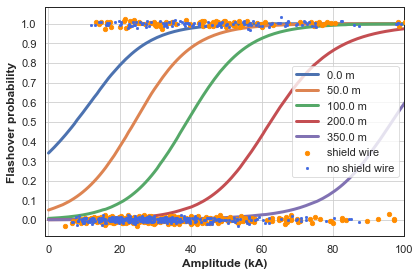

In [33]:
# Plot probability distributions for different distances
sandbox.marginal_plot(distances, yv, y_hat, g, 'ampl', 'Amplitude (kA)', 
                      save_fig=True)

##### Risk of flashover analysis

In [34]:
# PDF of lightning current amplitudes
pdfi = distlines.lightning_amplitudes_pdf(yv)

# Risk of flashover analysis
risk_values = {}
for d in distances:
    product = pdfi*y_hat[d][:,1]
    product = np.nan_to_num(product)
    risk = integrate.trapezoid(product, yv)
    print(d, '=>', risk.round(4))
    risk_values[d] = risk

0.0 => 0.8831
50.0 => 0.6562
100.0 => 0.3909
200.0 => 0.134
350.0 => 0.0287


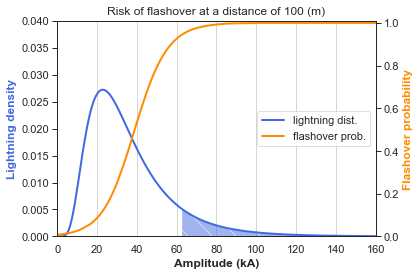

In [35]:
D = 100  # distance
fig, ax = plt.subplots(figsize=(6,4))
ax_twin = ax.twinx()  # second y-axis
ax.set_title(f"Risk of flashover at a distance of {D} (m)")
l1 = ax.plot(yv, pdfi, c='royalblue', lw=2, label='lightning dist.')
idx = np.argwhere(yv >= 62.)[0][0]
ax.fill_between(yv[idx:], pdfi[idx:], fc='royalblue', alpha =0.5, hatch='\\')
#l2 = ax.plot(yv, pdfi*y_hat[D][:,1], c='steelblue', lw=2, label='risk of flashover')
#ax.fill_between(yv, 0, pdfi*y_hat[D][:,1], color='steelblue', alpha=0.5, hatch='//',
#                label='risk of flashover')
ax.set_xlim(0, yv.max())
ax.set_ylim(0, 0.04)
l3 = ax_twin.plot(yv, y_hat[D][:,1], c='darkorange', lw=2, label='flashover prob.')
lns = l1 + l3 #+ l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right')
#ax_twin.annotate('R = {:.3f}'.format(risk_values[D]),
#                 xy=(50, 0.05), xycoords='data',
#                 xytext=(70, 0.4), textcoords='data',
#                 arrowprops=dict(arrowstyle='simple', facecolor='dimgrey'),
#                 horizontalalignment='left',
#                 verticalalignment='top',
#                 fontweight='bold')
ax.set_xlabel('Amplitude (kA)', fontweight='bold')
ax.set_ylabel('Lightning density', fontweight='bold')
ax.yaxis.label.set_color('royalblue')
ax_twin.set_ylabel('Flashover probability', fontweight='bold')
ax_twin.yaxis.label.set_color('darkorange')
ax_twin.set_ylim(0, 1.01)
ax.grid(axis='x')
fig.tight_layout()
plt.savefig('risk-1.png', dpi=600)
plt.show()

In [36]:
# Statistical safety factor (gama) is the quotient of a statistical overvoltage 
# (Vs) and a statistical withstand voltage (Vw): gama = Vs/Vw. Statistical 
# overvoltage is the amplitude which has only a 2% chance to cause a flashover.
# Statistical withstand is the value at which there is only a 10% chance of 
# flashover. We can adapt this reasoning here, but with the lightning current 
# amplitudes, such that Vs is taken at 10% and Vw at 10% chance, regarding the
# currents instead of voltages.

# Lightning amplitudes probability
cdf_values_lightning = sandbox.cdf_from_pdf(np.nan_to_num(pdfi))
inverse_cdf_lightning = interpolate.interp1d(cdf_values_lightning, yv)
Vs = inverse_cdf_lightning(0.9)  # 10% probability
print(f'Vs(10%) = {Vs:.2f} (kA)')

gama_values = []
for d in distances:
    print(f'\nDistance: {d} (m)')
    # Flashover probability
    inverse_cdf_flashover = interpolate.interp1d(y_hat[d][:,1], yv)
    try:
        Vw = inverse_cdf_flashover(0.1)  # 10% probability
    except ValueError:
        Vw = 0.1
    print(f'Vw(10%) = {Vw:.2f} (kA)')
    # Statistical safety factor
    gama = Vw/Vs
    print(f'Safety factor: {gama:.3f}')
    gama_values.append(gama)

Vs(10%) = 62.08 (kA)

Distance: 0.0 (m)
Vw(10%) = 0.10 (kA)
Safety factor: 0.002

Distance: 50.0 (m)
Vw(10%) = 6.35 (kA)
Safety factor: 0.102

Distance: 100.0 (m)
Vw(10%) = 21.33 (kA)
Safety factor: 0.344

Distance: 200.0 (m)
Vw(10%) = 43.96 (kA)
Safety factor: 0.708

Distance: 350.0 (m)
Vw(10%) = 76.14 (kA)
Safety factor: 1.226


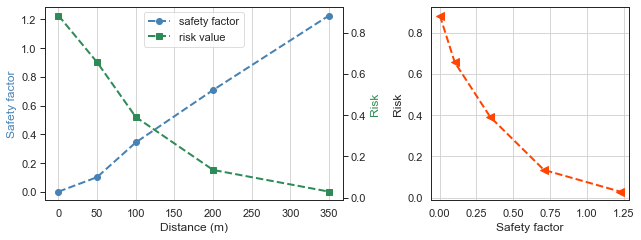

In [37]:
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.5),
                              gridspec_kw={'width_ratios': [1.5, 1]})
l1 = ax.plot(distances, gama_values, ls='--', c='steelblue', lw=2, marker='o', 
             markersize=6, label='safety factor')
ax_twin = ax.twinx()
l2 = ax_twin.plot(distances, risk_values.values(), ls='--', c='seagreen', lw=2, 
                  marker='s', markersize=6, label='risk value')
lns = l1 + l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper center')
ax.grid(which='major', axis='x')
ax_twin.set_ylabel('Risk')
#ax_twin.set_ylim(0, 1)
ax_twin.yaxis.label.set_color('seagreen')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Safety factor')
ax.yaxis.label.set_color('steelblue')
ax2.plot(gama_values, risk_values.values(), ls='--', c='orangered', lw=2,
         marker='<', markersize=8)
ax2.set_xlabel('Safety factor')
ax2.set_ylabel('Risk')
ax2.grid(which='major', axis='both')
#ax2.set_ylim(0, 1)
fig.tight_layout()
plt.savefig('safety_factor.png', dpi=600)
plt.show()

In [38]:
xv = np.linspace(0, 500, 200)
amplitudes = np.array([5., 15., 30., 60.])
y_hat = {}
for a in amplitudes:
    yv = np.array([a]*xv.size)
    X_values = np.c_[xv, yv]
    y_hat[a] = search.predict_proba(X_values)

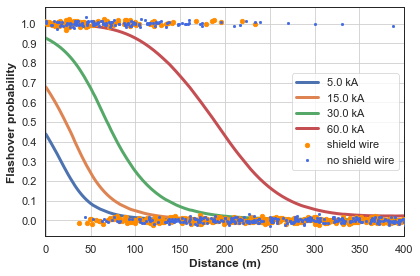

In [39]:
# Plot probability distributions for different amplitudes
sandbox.marginal_plot(amplitudes, xv, y_hat, g, 'dist', 'Distance (m)', xmax=400,
                      save_fig=False)

#### Test existing model with a new distribution line

In [40]:
# 10 m high distribution line
g = groups.get_group(12)
g.reset_index(inplace=True)
X_data_new_line = g[['dist', 'ampl']]  # add features here
y_data_new_line = g['flash']

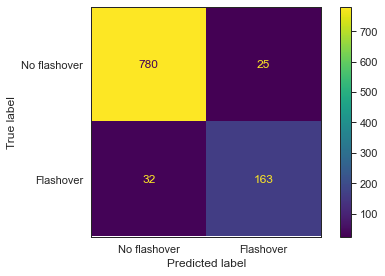

In [41]:
# Plot confusion matrix for estimator
ConfusionMatrixDisplay.from_estimator(
    search, X_data_new_line, y_data_new_line, 
    display_labels=['No flashover', 'Flashover'],
    # normalize='all',
)
plt.tight_layout()
plt.show()

In [42]:
y_test_hat = search.predict(X_data_new_line)
# Display classification report
print(classification_report(
      y_data_new_line, y_test_hat, 
      target_names=['No flashover', 'Flashover']))

              precision    recall  f1-score   support

No flashover       0.96      0.97      0.96       805
   Flashover       0.87      0.84      0.85       195

    accuracy                           0.94      1000
   macro avg       0.91      0.90      0.91      1000
weighted avg       0.94      0.94      0.94      1000



### Using additional data features in model building

Now we can extend the model with additional features from the original dataset to see how that reflects on the model's prediction performance (accuracy).

In [43]:
# prepare data
X_data = data[['dist', 'ampl', 'height', 'shield', 'Ri']]  # features
y_data = data['flash']

# Split data into training and test sets
X, y, X_test, y_test = sandbox.train_test_shuffle_split(X_data, y_data)

In [44]:
# Model training with hyperparameters optimization
model = sandbox.bagging_ensemble_svm(n_models, X, y, sample_pct=0.7)

Train model 1 of 3:
Working ...
Execution time (hour:min:sec): 0:01:03.068550
estimator__C :: 16.14497864279231
estimator__gamma :: scale
estimator__kernel :: rbf
preprocess :: None
Train model 2 of 3:
Working ...
Execution time (hour:min:sec): 0:00:17.803302
estimator__C :: 10.165639546801128
estimator__gamma :: scale
estimator__kernel :: linear
preprocess :: None
Train model 3 of 3:
Working ...
Execution time (hour:min:sec): 0:00:00.687782
estimator__C :: 84.2900790445335
estimator__gamma :: auto
estimator__kernel :: linear
preprocess :: StandardScaler()
Aggregating predictions:
With equal weights.
Working ...
Done.


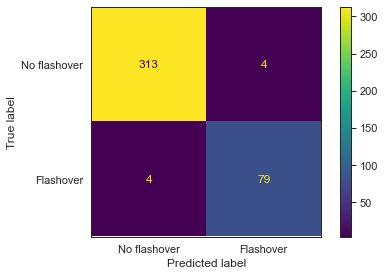

In [45]:
# Plot confusion matrix for estimator
ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, 
    display_labels=['No flashover', 'Flashover'],
)
plt.tight_layout()
plt.show()

In [46]:
y_hat = model.predict(X_test)
# Display classification report
print(classification_report(
      y_test, y_hat, 
      target_names=['No flashover', 'Flashover']))

              precision    recall  f1-score   support

No flashover       0.99      0.99      0.99       317
   Flashover       0.95      0.95      0.95        83

    accuracy                           0.98       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.98      0.98      0.98       400



__Note__: We can see from the confusion matrix and the classification report that the newly trained model with additional features has much better overall performance, compared to the previous model that was trained with only two features. Hence, this approach enables building a single model that can be employed for flashover analysis on distribution lines of different heights and geometry.

#### CLP from the model with additional features

In [47]:
support_vectors = []
for i in range(n_models):
    supports = model.estimators_[i].support_vectors_
    support_vectors.append(supports)
support_vectors = np.concatenate(support_vectors)
vectors = np.unique(support_vectors, axis=0)

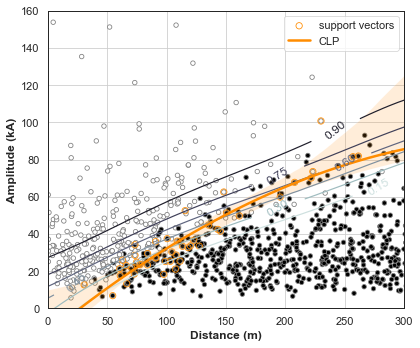

In [48]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(X[:,0], X[:,1], c=y, edgecolors='grey', cmap=plt.cm.bone, s=20)
ax.scatter(vectors[:,0], vectors[:,1], facecolor='none', 
           edgecolor='darkorange', s=40, label='support vectors')
# Show contour lines
contour = plt.contour(xx, yy, zz, cmap=plt.cm.bone_r)
plt.clabel(contour, inline=1, fontsize=12)
# Fit and plot CLP regression curve through the support vectors
sns.regplot(x=vectors[:,0], y=vectors[:,1], fit_reg=True, 
            order=2,  # second order polynomial
            truncate=False, scatter=False, color='darkorange',
            line_kws={'lw': 2.5},
            ax=ax, label='CLP')
ax.legend(loc='upper right', frameon='fancy', fancybox=True)
ax.set_xlabel('Distance (m)', fontweight='bold')
ax.set_ylabel('Amplitude (kA)', fontweight='bold')
ax.set_xlim(0,300)
ax.set_ylim(0,160)
ax.grid()
fig.tight_layout()
plt.show()